<a href="https://colab.research.google.com/github/ariesharry/Data-Science/blob/main/Fuzzy_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np


def _best(population, fitness_func, best, fbest):

    # best, fbest = None, None
    for i in range(population[0].shape[0]):

        if population[1][i] > -1.0:
            tmp = population[1][i]
        else:
            tmp = fitness_func(population[0][i])
            population[1][i] = tmp

        if best is None or tmp < fbest:
            best = population[0][i]
            fbest = tmp

    return best.copy(), fbest.copy()


def _tournament_selection(population, fitness_func):

    # k == 2
    idxs = np.random.permutation(np.arange(population[0].shape[0]))

    parent1 = population[0][idxs[0], :]
    parent2 = population[0][idxs[1], :]

    if population[1][idxs[0]] > -1.0:
        fitness1 = population[1][idxs[0]] 
    else:
        fitness1 = fitness_func(parent1)
        population[1][idxs[0]] = fitness1

    if population[1][idxs[1]] > -1.0:
        fitness2 = population[1][idxs[1]] 
    else:
        fitness2 = fitness_func(parent2)
        population[1][idxs[1]] = fitness2

    return parent1 if fitness1 < fitness2 else parent2


def _individuals(size):
    return np.random.rand(size)


# Function that mutates an individual
def _mutate(individual):

    idx = np.random.randint(low=0, high=individual.shape[0])
    individual[idx] = np.random.rand()
    return individual

def _crossover(male, female, alpha=0.9):
    """
    BLX-alpha crossover
    """
    shift = np.abs(male - female) * alpha

    mmin = np.amin([male, female], axis=0) - shift
    mmax = np.amax([male, female], axis=0) + shift

    mmin = np.clip(mmin, 0, 1)
    mmax = np.clip(mmax, 0, 1)

    offspring1 = np.random.uniform(low=mmin, high=mmax)
    offspring2 = np.random.uniform(low=mmin, high=mmax)

    return offspring1, offspring2  


def genetic_algorithm(fitness_func, dim, n_individuals=10, epochs=50, crossover_rate=0.9, mutation_rate=0.1, verbose=False):
    
    assert n_individuals % 2 == 0
    
    population = [np.array([_individuals(dim) for _ in range(n_individuals)]),
                  np.zeros(n_individuals) - 1.0]

    children = np.zeros((n_individuals, dim))

    best, fbest = None, None

    for e in range(epochs):
        for c in range(0, n_individuals, 2):

            parent1 = _tournament_selection(population, fitness_func)
            parent2 = _tournament_selection(population, fitness_func)

            while np.array_equal(parent1, parent2):
                parent2 = _tournament_selection(population, fitness_func)

            if np.random.uniform() < crossover_rate:
                offspring1, offspring2 = _crossover(parent1, parent2)
                children[c, :] = offspring1
                children[c+1, :] = offspring2
            else:
                children[c, :] = parent1
                children[c+1, :] = parent2

            if np.random.uniform() < mutation_rate:
                children[c, :] = _mutate(children[c, :])

            if np.random.uniform() < mutation_rate:
                children[c+1, :] = _mutate(children[c+1, :])

        best, fbest = _best(population, fitness_func, best, fbest)

        population[0][:] = children[:]
        population[1][:] = -1.0
        children[:] = 0.0

        if verbose:
            print('epoch {:2d}, best fitness = {:.10f}'.format(e, fbest))

    return best, fbest
    

In [ ]:
#------------------------------------------------------------------------------+
#
#	Nathan A. Rooy
#	Simple Particle Swarm Optimization (PSO) with Python
#	Last update: 2018-JAN-26
#	Python 3.6
#
#------------------------------------------------------------------------------+

#--- IMPORT DEPENDENCIES ------------------------------------------------------+

from __future__ import division
from random import random
from random import uniform

#--- MAIN ---------------------------------------------------------------------+

class Particle:
    def __init__(self,x0):
        self.position_i=[]          # particle position
        self.velocity_i=[]          # particle velocity
        self.pos_best_i=[]          # best position individual
        self.err_best_i=-1          # best error individual
        self.err_i=-1               # error individual

        for i in range(0,num_dimensions):
            self.velocity_i.append(uniform(-1,1))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self,costFunc):
        self.err_i=costFunc(self.position_i)

        # check to see if the current position is an individual best
        if self.err_i<self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i.copy()
            self.err_best_i=self.err_i
                    
    # update new particle velocity
    def update_velocity(self,pos_best_g):
        w=0.5       # constant inertia weight (how much to weigh the previous velocity)
        c1=1        # cognative constant
        c2=2        # social constant
        
        for i in range(0,num_dimensions):
            r1=random()
            r2=random()
            
            vel_cognitive=c1*r1*(self.pos_best_i[i]-self.position_i[i])
            vel_social=c2*r2*(pos_best_g[i]-self.position_i[i])
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    # update the particle position based off new velocity updates
    def update_position(self,bounds):
        for i in range(0,num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]
            
            # adjust maximum position if necessary
            if self.position_i[i]>bounds[i][1]:
                self.position_i[i]=bounds[i][1]

            # adjust minimum position if neseccary
            if self.position_i[i]<bounds[i][0]:
                self.position_i[i]=bounds[i][0]
        
        
def minimize(costFunc, x0, bounds, num_particles, maxiter, verbose=False):
    global num_dimensions

    num_dimensions=len(x0)
    err_best_g=-1                   # best error for group
    pos_best_g=[]                   # best position for group

    # establish the swarm
    swarm=[]
    for i in range(0,num_particles):
        swarm.append(Particle(x0))

    # begin optimization loop
    i=0
    while i<maxiter:
        if verbose: print(f'iter: {i:>4d}, best solution: {err_best_g:10.6f}')
            
        # cycle through particles in swarm and evaluate fitness
        for j in range(0,num_particles):
            swarm[j].evaluate(costFunc)

            # determine if current particle is the best (globally)
            if swarm[j].err_i<err_best_g or err_best_g==-1:
                pos_best_g=list(swarm[j].position_i)
                err_best_g=float(swarm[j].err_i)
        
        # cycle through swarm and update velocities and position
        for j in range(0,num_particles):
            swarm[j].update_velocity(pos_best_g)
            swarm[j].update_position(bounds)
        i+=1

    if verbose:
        # print final results
        print('\nFINAL SOLUTION:')
        print(f'   > {pos_best_g}')
        print(f'   > {err_best_g}\n')

    return pos_best_g, err_best_g

#--- END ----------------------------------------------------------------------+

In [3]:
!pip install scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 993 kB 31.8 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894088 sha256=94051ba67fd84ab29c742e9768836fc3b5f586d2250a6b1ba7ef17c6dff55345
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy


100%|██████████| 30/30 [00:09<00:00,  3.32it/s]

GA:
0.96 0.9333333333333333
0.9497777777777777 0.008024653371230131
PSO:
0.9666666666666667 0.94
0.9542222222222222 0.007450246495217874


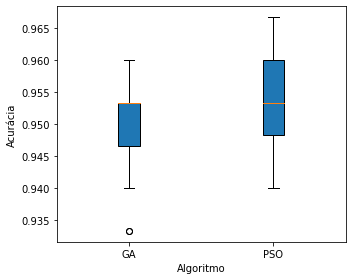

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn import datasets
from tqdm import tqdm
import matplotlib.pyplot as plt
import pso_simple

# https://github.com/nathanrooy/particle-swarm-optimization

def normalize_dataset(dataset):
	# Normalize the dataset to [0, 1]
	min_arr = np.amin(dataset, axis=0)
	return (dataset - min_arr) / (np.amax(dataset, axis=0) - min_arr)


def evaluate_new_fuzzy_system(w1, w2, w3, w4, data, target):

	universe = np.linspace(0, 1, 100)

	x = []
	for w in [w1, w2, w3, w4]:
		x.append({'s': fuzz.trimf(universe, [0.0, 0.0, w]),
		          'm': fuzz.trimf(universe, [0.0, w, 1.0]),
			      'l': fuzz.trimf(universe, [w, 1.0, 1.0])})

	x_memb = []
	for i in range(4):
		x_memb.append({})
		for t in ['s', 'm', 'l']:
			x_memb[i][t] = fuzz.interp_membership(universe, x[i][t], data[:, i])

	is_setosa = np.fmin(np.fmax(x_memb[2]['s'], x_memb[2]['m']), x_memb[3]['s'])
	is_versicolor = np.fmax(np.fmin(np.fmin(np.fmin(np.fmax(x_memb[0]['s'], x_memb[0]['l']), np.fmax(x_memb[1]['m'], x_memb[1]['l'])), np.fmax(x_memb[2]['m'], x_memb[2]['l'])),x_memb[3]['m']), np.fmin(x_memb[0]['m'], np.fmin(np.fmin(np.fmax(x_memb[1]['s'], x_memb[1]['m']),x_memb[2]['s']), x_memb[3]['l'])))
	is_virginica = np.fmin(np.fmin(np.fmax(x_memb[1]['s'], x_memb[1]['m']), x_memb[2]['l']), x_memb[3]['l'])

	result = np.argmax([is_setosa, is_versicolor, is_virginica], axis=0)

	return (result == target).mean()


def main():
	
	iris = datasets.load_iris()
	normalized_iris = normalize_dataset(iris.data)
	n_features = normalized_iris.shape[1]

	fitness = lambda w: 1.0 - evaluate_new_fuzzy_system(w[0], w[1], w[2], w[3], normalized_iris, iris.target)

	# Test Fuzzy
	# w = [0.07, 0.34, 0.48, 0.26] # 95%
	# w = [0, 0.21664307088134033, 0.445098590128248, 0.2350617110613577] # 96.6%
	# print(1.0 - fitness(w))

	record = {'GA': [], 'PSO': []}

	for _ in tqdm(range(30)):

		# GA
		best, fbest = genetic_algorithm(fitness_func=fitness, dim=n_features, n_individuals=10, epochs=30, verbose=False)
		record['GA'].append(1.0 - fbest)

		# PSO
		initial=[0.5, 0.5, 0.5, 0.5]             
		bounds=[(0, 1), (0, 1), (0, 1), (0, 1)] 
		best, fbest = pso_simple.minimize(fitness, initial, bounds, num_particles=10, maxiter=30, verbose=False)
		record['PSO'].append(1.0 - fbest)


	# Statistcs about the runs
	print('GA:')
	print(np.amax(record['GA']), np.amin(record['GA']))
	print(np.mean(record['GA']), np.std(record['GA']))

	print('PSO:')
	print(np.amax(record['PSO']), np.amin(record['PSO']))
	print(np.mean(record['PSO']), np.std(record['PSO']))


	fig, ax = plt.subplots(figsize=(5, 4))

	ax.boxplot(list(record.values()), vert=True, patch_artist=True, labels=list(record.keys())) 

	ax.set_xlabel('Algoritmo')
	ax.set_ylabel('Acurácia')

	plt.tight_layout()
	plt.show()
	

if __name__ == '__main__':
	main()